In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib as mpl
import matplotlib.pyplot as plt
import logging
from pprint import pprint
from IPython.display import clear_output

In [2]:
print(tf.__version__)

logging.basicConfig(level="error")
np.set_printoptions(suppress=True)

2.0.0-beta0


In [3]:
output_dir = "nmt"
en_vocab_file = os.path.join(output_dir, "en_vocab")
zh_vocab_file = os.path.join(output_dir, "zh_vocab")
checkpoint_path = os.path.join(output_dir, "checkpoints")
log_dir = os.path.join(output_dir, 'logs')
download_dir = "tensorflow-datasets/downloads"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [4]:
tmp_builder = tfds.builder("wmt19_translate/zh-en")
pprint(tmp_builder.subsets)

{NamedSplit('train'): ['newscommentary_v14',
                       'wikititles_v1',
                       'uncorpus_v1',
                       'casia2015',
                       'casict2011',
                       'casict2015',
                       'datum2015',
                       'datum2017',
                       'neu2017'],
 NamedSplit('validation'): ['newsdev2017', 'newstest2017', 'newstest2018']}


In [5]:
config = tfds.translate.wmt.WmtConfig(
  version="0.0.2",
  language_pair=("zh", "en"),
  subsets={
    tfds.Split.TRAIN: ["newscommentary_v14"]
  }
)
builder = tfds.builder("wmt_translate", config=config)
builder.download_and_prepare(download_dir=download_dir)
clear_output()

In [6]:
train_perc = 20
val_prec = 1
drop_prec = 100 - train_perc - val_prec

split = tfds.Split.TRAIN.subsplit([train_perc, val_prec, drop_prec])
split

(NamedSplit('train')(tfds.percent[0:20]),
 NamedSplit('train')(tfds.percent[20:21]),
 NamedSplit('train')(tfds.percent[21:100]))

In [7]:
examples = builder.as_dataset(split=split, as_supervised=True)
train_examples, val_examples, _ = examples
print(train_examples)
print(val_examples)

<_OptionsDataset shapes: ((), ()), types: (tf.string, tf.string)>
<_OptionsDataset shapes: ((), ()), types: (tf.string, tf.string)>


In [8]:
for en, zh in train_examples.take(3):
    print(en)
    print(zh)
    print('-' * 10)

tf.Tensor(b'Making Do With More', shape=(), dtype=string)
tf.Tensor(b'\xe5\xa4\x9a\xe5\x8a\xb3\xe5\xba\x94\xe5\xa4\x9a\xe5\xbe\x97', shape=(), dtype=string)
----------
tf.Tensor(b'If the Putins, Erdo\xc4\x9fans, and Orb\xc3\xa1ns of the world want to continue to benefit economically from the open international system, they cannot simply make up their own rules.', shape=(), dtype=string)
tf.Tensor(b'\xe5\xa6\x82\xe6\x9e\x9c\xe6\x99\xae\xe4\xba\xac\xe3\x80\x81\xe5\x9f\x83\xe5\xb0\x94\xe5\xa4\x9a\xe5\xae\x89\xe5\x92\x8c\xe6\xac\xa7\xe5\xb0\x94\xe7\x8f\xad\xe5\xb8\x8c\xe6\x9c\x9b\xe7\xbb\xa7\xe7\xbb\xad\xe4\xba\xab\xe6\x9c\x89\xe5\xbc\x80\xe6\x94\xbe\xe5\x9b\xbd\xe9\x99\x85\xe4\xbd\x93\xe7\xb3\xbb\xe6\x8f\x90\xe4\xbe\x9b\xe7\x9a\x84\xe7\xbb\x8f\xe6\xb5\x8e\xe5\x88\xa9\xe7\x9b\x8a\xef\xbc\x8c\xe5\xb0\xb1\xe4\xb8\x8d\xe8\x83\xbd\xe7\xae\x80\xe5\x8d\x95\xe5\x9c\xb0\xe5\x88\xb6\xe5\xae\x9a\xe8\x87\xaa\xe5\xb7\xb1\xe7\x9a\x84\xe8\xa7\x84\xe5\x88\x99\xe3\x80\x82', shape=(), dtype=string)
-------

In [9]:
sample_examples = []
num_samples = 3

for en_t, zh_t in train_examples.take(num_samples):
    en = en_t.numpy().decode("utf-8")
    zh = zh_t.numpy().decode("utf-8")
  
    print(en)
    print(zh)
    print('-' * 10)
  
    # 之後用來簡單評估模型的訓練情況
    sample_examples.append((en, zh))

Making Do With More
多劳应多得
----------
If the Putins, Erdoğans, and Orbáns of the world want to continue to benefit economically from the open international system, they cannot simply make up their own rules.
如果普京、埃尔多安和欧尔班希望继续享有开放国际体系提供的经济利益，就不能简单地制定自己的规则。
----------
This ceiling can be raised only in a deep depression or other exceptional circumstances, allowing for counter-cyclical policy so long as it is agreed that the additional deficit is cyclical, rather than structural.
只有在发生深度萧条或其他反常事件时，这一上限才能做出调整，以便让反周期政策实施足够的长度，使人们一致认为增加的赤字是周期性的，而不是结构性的。
----------


In [10]:
try:
    subword_encoder_en = tfds.features.text.SubwordTextEncoder.load_from_file(en_vocab_file)
    print(f"載入已建立的字典： {en_vocab_file}")
except:
    print("沒有已建立的字典，從頭建立。")
    subword_encoder_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
            (en.numpy() for en, _ in train_examples), target_vocab_size=2**13) # 有需要可以調整字典大小
  
    # 將字典檔案存下以方便下次 warmstart
    subword_encoder_en.save_to_file(en_vocab_file)

print(f"字典大小：{subword_encoder_en.vocab_size}")
print(f"前 10 個 subwords：{subword_encoder_en.subwords[:10]}")
print()

載入已建立的字典： nmt/en_vocab
字典大小：8135
前 10 個 subwords：[', ', 'the_', 'of_', 'to_', 'and_', 's_', 'in_', 'a_', 'that_', 'is_']



In [12]:
sample_string = 'Taiwan is beautiful.'
indices = subword_encoder_en.encode(sample_string)
indices

[2700, 7911, 10, 2942, 7457, 1163, 7925]

In [13]:
print("{0:10}{1:6}".format("Index", "Subword"))
print("-" * 15)
for idx in indices:
    subword = subword_encoder_en.decode([idx])
    print('{0:5}{1:6}'.format(idx, ' ' * 5 + subword))

Index     Subword
---------------
 2700     Taiwan
 7911      
   10     is 
 2942     bea
 7457     uti
 1163     ful
 7925     .


In [14]:
sample_string = 'Taiwan is beautiful.'
indices = subword_encoder_en.encode(sample_string)
decoded_string = subword_encoder_en.decode(indices)
assert decoded_string == sample_string
pprint((sample_string, decoded_string))

('Taiwan is beautiful.', 'Taiwan is beautiful.')


In [15]:
try:
    subword_encoder_zh = tfds.features.text.SubwordTextEncoder.load_from_file(zh_vocab_file)
    print(f"載入已建立的字典： {zh_vocab_file}")
except:
    print("沒有已建立的字典，從頭建立。")
    subword_encoder_zh = tfds.features.text.SubwordTextEncoder.build_from_corpus(
                        (zh.numpy() for _, zh in train_examples), target_vocab_size=2**13, max_subword_length=1) 
                        # 每一個中文字就是字典裡的一個單位
  
    # 將字典檔案存下以方便下次 warmstart 
    subword_encoder_zh.save_to_file(zh_vocab_file)

print(f"字典大小：{subword_encoder_zh.vocab_size}")
print(f"前 10 個 subwords：{subword_encoder_zh.subwords[:10]}")
print()

載入已建立的字典： nmt/zh_vocab
字典大小：4201
前 10 個 subwords：['的', '，', '。', '国', '在', '是', '一', '和', '不', '这']



In [16]:
en = "The eurozone’s collapse forces a major realignment of European politics."
zh = "欧元区的瓦解强迫欧洲政治进行一次重大改组。"

# 將文字轉成為 subword indices
en_indices = subword_encoder_en.encode(en)
zh_indices = subword_encoder_zh.encode(zh)

print("[英中原文]（轉換前）")
print(en)
print(zh)
print()
print('-' * 20)
print()
print("[英中序列]（轉換後）")
print(en_indices)
print(zh_indices)

[英中原文]（轉換前）
The eurozone’s collapse forces a major realignment of European politics.
欧元区的瓦解强迫欧洲政治进行一次重大改组。

--------------------

[英中序列]（轉換後）
[17, 965, 11, 6, 1707, 676, 8, 211, 2712, 6683, 249, 3, 85, 1447, 7925]
[45, 206, 171, 1, 847, 197, 236, 604, 45, 90, 17, 130, 102, 36, 7, 284, 80, 18, 212, 265, 3]


In [17]:
def encode(en_t, zh_t):
    # 因為字典的索引從 0 開始，
    # 我們可以使用 subword_encoder_en.vocab_size 這個值作為 BOS 的索引值
    # 用 subword_encoder_en.vocab_size + 1 作為 EOS 的索引值
    en_indices = [subword_encoder_en.vocab_size] + subword_encoder_en.encode(
                                    en_t.numpy()) + [subword_encoder_en.vocab_size + 1]
    # 同理，不過是使用中文字典的最後一個索引 + 1
    zh_indices = [subword_encoder_zh.vocab_size] + subword_encoder_zh.encode(
                                    zh_t.numpy()) + [subword_encoder_zh.vocab_size + 1]
  
    return en_indices, zh_indices

In [18]:
en_t, zh_t = next(iter(train_examples))
en_indices, zh_indices = encode(en_t, zh_t)
print('英文 BOS 的 index：', subword_encoder_en.vocab_size)
print('英文 EOS 的 index：', subword_encoder_en.vocab_size + 1)
print('中文 BOS 的 index：', subword_encoder_zh.vocab_size)
print('中文 EOS 的 index：', subword_encoder_zh.vocab_size + 1)

print('\n輸入為 2 個 Tensors：')
pprint((en_t, zh_t))
print('-' * 15)
print('輸出為 2 個索引序列：')
pprint((en_indices, zh_indices))

英文 BOS 的 index： 8135
英文 EOS 的 index： 8136
中文 BOS 的 index： 4201
中文 EOS 的 index： 4202

輸入為 2 個 Tensors：
(<tf.Tensor: id=266, shape=(), dtype=string, numpy=b'Making Do With More'>,
 <tf.Tensor: id=267, shape=(), dtype=string, numpy=b'\xe5\xa4\x9a\xe5\x8a\xb3\xe5\xba\x94\xe5\xa4\x9a\xe5\xbe\x97'>)
---------------
輸出為 2 個索引序列：
([8135, 4682, 19, 717, 7911, 298, 2701, 7980, 8136],
 [4201, 48, 557, 116, 48, 81, 4202])


In [19]:
def tf_encode(en_t, zh_t):
    # 在 `tf_encode` 函式裡頭的 `en_t` 與 `zh_t` 都不是 Eager Tensors
    # 要到 `tf.py_funtion` 裡頭才是
    # 另外因為索引都是整數，所以使用 `tf.int64`
    return tf.py_function(encode, [en_t, zh_t], [tf.int64, tf.int64])

# `tmp_dataset` 為說明用資料集，說明完所有重要的 func，
# 我們會從頭建立一個正式的 `train_dataset`
tmp_dataset = train_examples.map(tf_encode)
en_indices, zh_indices = next(iter(tmp_dataset))
print(en_indices)
print(zh_indices)

W0730 16:03:25.068456 123145432698880 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0730 16:03:25.072432 123145432698880 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string


tf.Tensor([8135 4682   19  717 7911  298 2701 7980 8136], shape=(9,), dtype=int64)
tf.Tensor([4201   48  557  116   48   81 4202], shape=(7,), dtype=int64)


In [20]:
MAX_LENGTH = 40

def filter_max_length(en, zh, max_length=MAX_LENGTH):
    # en, zh 分別代表英文與中文的索引序列
    return tf.logical_and(tf.size(en) <= max_length,
                        tf.size(zh) <= max_length)

# tf.data.Dataset.filter(func) 只會回傳 func 為真的例子
tmp_dataset = tmp_dataset.filter(filter_max_length)

In [21]:
# 因為我們數據量小可以這樣 count
num_examples = 0
for en_indices, zh_indices in tmp_dataset:
    cond1 = len(en_indices) <= MAX_LENGTH
    cond2 = len(zh_indices) <= MAX_LENGTH
    assert cond1 and cond2
    num_examples += 1

print(f"所有英文與中文序列長度都不超過 {MAX_LENGTH} 個 tokens")
print(f"訓練資料集裡總共有 {num_examples} 筆數據")

W0730 16:03:26.104511 123145432698880 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0730 16:03:26.107712 123145432698880 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0730 16:03:26.126374 123145433235456 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string


所有英文與中文序列長度都不超過 40 個 tokens
訓練資料集裡總共有 29914 筆數據


In [22]:
BATCH_SIZE = 64
# 將 batch 裡的所有序列都 pad 到同樣長度
tmp_dataset = tmp_dataset.padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))
en_batch, zh_batch = next(iter(tmp_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8135 4682   19 ...    0    0    0]
 [8135   17  965 ... 8136    0    0]
 [8135 6602    2 ...    0    0    0]
 ...
 [8135 1097  270 ...    0    0    0]
 [8135 1713   70 ...    0    0    0]
 [8135 2731 4553 ...    0    0    0]], shape=(64, 34), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4201   48  557 ...    0    0    0]
 [4201   45  206 ...    0    0    0]
 [4201   58    5 ...  683    3 4202]
 ...
 [4201   29  120 ...    0    0    0]
 [4201  297  161 ...    0    0    0]
 [4201  279  149 ... 4202    0    0]], shape=(64, 40), dtype=int64)


In [23]:
MAX_LENGTH = 40
BATCH_SIZE = 128
BUFFER_SIZE = 15000

# 訓練集
train_dataset = (train_examples  # 輸出：(英文句子, 中文句子)
                 .map(tf_encode) # 輸出：(英文索引序列, 中文索引序列)
                 .filter(filter_max_length) # 同上，且序列長度都不超過 40
                 .cache() # 加快讀取數據
                 .shuffle(BUFFER_SIZE) # 將例子洗牌確保隨機性
                 .padded_batch(BATCH_SIZE, # 將 batch 裡的序列都 pad 到一樣長度
                               padded_shapes=([-1], [-1]))
                 .prefetch(tf.data.experimental.AUTOTUNE)) # 加速
# 驗證集
val_dataset = (val_examples
               .map(tf_encode)
               .filter(filter_max_length)
               .padded_batch(BATCH_SIZE, 
                             padded_shapes=([-1], [-1])))

In [24]:
en_batch, zh_batch = next(iter(train_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8135  340    2 ...    0    0    0]
 [8135 1925 3150 ...    0    0    0]
 [8135 1562 7864 ...    0    0    0]
 ...
 [8135  258    1 ...    0    0    0]
 [8135 2189    1 ...    0    0    0]
 [8135  263  637 ...    0    0    0]], shape=(128, 35), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4201    5   22 ...    0    0    0]
 [4201   34   92 ...    0    0    0]
 [4201  287  179 ...    0    0    0]
 ...
 [4201   78  131 ...   57    3 4202]
 [4201   44  263 ...    0    0    0]
 [4201   17  130 ...    0    0    0]], shape=(128, 40), dtype=int64)


In [25]:
demo_examples = [
    ("It is important.", "这很重要。"),
    ("The numbers speak for themselves.", "数字证明了一切。"),
]
pprint(demo_examples)

[('It is important.', '这很重要。'),
 ('The numbers speak for themselves.', '数字证明了一切。')]


In [26]:
batch_size = 2
demo_examples = tf.data.Dataset.from_tensor_slices((
    [en for en, _ in demo_examples], [zh for _, zh in demo_examples]
))

# 將兩個句子透過之前定義的字典轉換成子詞的序列（sequence of subwords）
# 並添加 padding token: <pad> 來確保 batch 裡的句子有一樣長度
demo_dataset = demo_examples.map(tf_encode).padded_batch(batch_size, padded_shapes=([-1], [-1]))

# 取出這個 demo dataset 裡唯一一個 batch
inp, tar = next(iter(demo_dataset))
print('inp:', inp)
print('' * 10)
print('tar:', tar)

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)


In [27]:
# + 2 是因為我們額外加了 <start> 以及 <end> tokens
vocab_size_en = subword_encoder_en.vocab_size + 2
vocab_size_zh = subword_encoder_zh.vocab_size + 2

# 為了方便 demo, 將詞彙轉換到一個 4 維的詞嵌入空間
d_model = 4
embedding_layer_en = tf.keras.layers.Embedding(vocab_size_en, d_model)
embedding_layer_zh = tf.keras.layers.Embedding(vocab_size_zh, d_model)

emb_inp = embedding_layer_en(inp)
emb_tar = embedding_layer_zh(tar)
emb_inp, emb_tar

(<tf.Tensor: id=626680, shape=(2, 8, 4), dtype=float32, numpy=
 array([[[ 0.03007313,  0.02036906, -0.04125573,  0.01857705],
         [ 0.02485183, -0.01075993,  0.04141906,  0.02836778],
         [ 0.0008044 , -0.02707223,  0.00271561, -0.01928517],
         [-0.00530639,  0.031064  , -0.02788754,  0.00026987],
         [-0.02277464, -0.03381418, -0.01702801,  0.01567436],
         [-0.02092762,  0.00006746,  0.04843903, -0.01837404],
         [ 0.0071398 , -0.04966588, -0.01519437, -0.04083735],
         [ 0.0071398 , -0.04966588, -0.01519437, -0.04083735]],
 
        [[ 0.03007313,  0.02036906, -0.04125573,  0.01857705],
         [-0.01984407,  0.04699245, -0.03227808,  0.01867528],
         [-0.04619816, -0.00495159, -0.0100555 ,  0.0122123 ],
         [-0.00798279,  0.00079347,  0.04289271,  0.02574532],
         [-0.02718923, -0.03666124,  0.01758217, -0.04951917],
         [ 0.01008735,  0.04031242,  0.03144382, -0.03819485],
         [-0.02277464, -0.03381418, -0.01702801,  0.

In [28]:
print("tar[0]:", tar[0][-3:])
print("-" * 20)
print("emb_tar[0]:", emb_tar[0][-3:])

tar[0]: tf.Tensor([0 0 0], shape=(3,), dtype=int64)
--------------------
emb_tar[0]: tf.Tensor(
[[ 0.01045633  0.04103506 -0.02072878  0.04457954]
 [ 0.01045633  0.04103506 -0.02072878  0.04457954]
 [ 0.01045633  0.04103506 -0.02072878  0.04457954]], shape=(3, 4), dtype=float32)


In [29]:
def create_padding_mask(seq):
  # padding mask 的工作就是把索引序列中為 0 的位置設為 1
    mask = tf.cast(tf.equal(seq, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :] #　broadcasting

inp_mask = create_padding_mask(inp)
inp_mask

<tf.Tensor: id=626721, shape=(2, 1, 1, 8), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 1., 1.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0.]]]], dtype=float32)>

In [30]:
print("inp:", inp)
print("-" * 20)
print("tf.squeeze(inp_mask):", tf.squeeze(inp_mask))

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)
--------------------
tf.squeeze(inp_mask): tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]], shape=(2, 8), dtype=float32)


In [31]:
# 設定一個 seed 確保我們每次都拿到一樣的隨機結果
tf.random.set_seed(9527)

# 自注意力機制：查詢 `q` 跟鍵值 `k` 都是 `emb_inp`
q = emb_inp
k = emb_inp
# 簡單產生一個跟 `emb_inp` 同樣 shape 的 binary vector
v = tf.cast(tf.math.greater(tf.random.uniform(shape=emb_inp.shape), 0.5), tf.float32)
v

<tf.Tensor: id=626735, shape=(2, 8, 4), dtype=float32, numpy=
array([[[1., 0., 0., 0.],
        [0., 1., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 1.]],

       [[1., 0., 1., 1.],
        [1., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.]]], dtype=float32)>

In [32]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
  
    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k). Defaults to None.
    
    Returns:
        output, attention_weights
    """
    # 將 `q`、 `k` 做點積再 scale
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    dk = tf.cast(tf.shape(k)[-1], tf.float32)  # 取得 seq_k 的序列長度
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  # scale by sqrt(dk)

      # 將遮罩「加」到被丟入 softmax 前的 logits
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # 取 softmax 是為了得到總和為 1 的比例之後對 `v` 做加權平均
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
  
    # 以注意權重對 v 做加權平均（weighted average）
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [33]:
mask = None
output, attention_weights = scaled_dot_product_attention(q, k, v, mask)
print("output:", output)
print("-" * 20)
print("attention_weights:", attention_weights)

output: tf.Tensor(
[[[0.37533218 0.37475923 0.37506354 0.4997114 ]
  [0.37484783 0.375215   0.37482142 0.50021344]
  [0.37481385 0.37505233 0.37500727 0.50008845]
  [0.37525868 0.37482274 0.37508383 0.4997896 ]
  [0.37501314 0.3749298  0.37510782 0.49993995]
  [0.37471038 0.37526017 0.37488708 0.5002938 ]
  [0.37473467 0.374995   0.37506884 0.5000576 ]
  [0.37473467 0.374995   0.37506884 0.5000576 ]]

 [[0.6253068  0.24981293 0.6251744  0.37505788]
  [0.6253271  0.24979836 0.6251568  0.37490964]
  [0.6249401  0.2498866  0.6248054  0.3748016 ]
  [0.62497187 0.24996498 0.6250671  0.3748533 ]
  [0.624575   0.25029796 0.62467957 0.37507337]
  [0.62505054 0.25027132 0.6252671  0.37519968]
  [0.62486184 0.2498731  0.624723   0.37484658]
  [0.62480235 0.25020278 0.6249817  0.37498307]]], shape=(2, 8, 4), dtype=float32)
--------------------
attention_weights: tf.Tensor(
[[[0.1252251  0.12497365 0.12495215 0.12511633 0.12499074 0.12482912
   0.12495645 0.12495645]
  [0.12496529 0.12520966 0.124

In [34]:
def create_padding_mask(seq):
  # padding mask 的工作就是把索引序列中為 0 的位置設為 1
    mask = tf.cast(tf.equal(seq, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :] #　broadcasting

print("inp:", inp)
inp_mask = create_padding_mask(inp)
print("-" * 20)
print("inp_mask:", inp_mask)

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)
--------------------
inp_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 8), dtype=float32)


In [35]:
# 這次讓我們將 padding mask 放入注意函式並觀察
# 注意權重的變化
mask = tf.squeeze(inp_mask, axis=1) # (batch_size, 1, seq_len_q)
_, attention_weights = scaled_dot_product_attention(q, k, v, mask)
print("attention_weights:", attention_weights)

attention_weights: tf.Tensor(
[[[0.16694741 0.1666122  0.16658352 0.16680242 0.16663498 0.1664195
   0.         0.        ]
  [0.16659322 0.166919   0.16663739 0.16651328 0.16660911 0.16672803
   0.         0.        ]
  [0.16658242 0.16665526 0.16675828 0.16658835 0.16671124 0.16670446
   0.         0.        ]
  [0.16681398 0.16654378 0.16660102 0.16682585 0.16664065 0.16657466
   0.         0.        ]
  [0.16662367 0.16661677 0.16670105 0.1666178  0.16683856 0.16660213
   0.         0.        ]
  [0.16642356 0.16675107 0.16670963 0.16656716 0.1666175  0.16693106
   0.         0.        ]
  [0.16659035 0.16657808 0.16684254 0.16657043 0.16676237 0.1666562
   0.         0.        ]
  [0.16659035 0.16657808 0.16684254 0.16657043 0.16676237 0.1666562
   0.         0.        ]]

 [[0.12524493 0.12516183 0.12498126 0.12493961 0.12483379 0.12497915
   0.12501054 0.12484889]
  [0.12511127 0.12523355 0.1250611  0.12493955 0.1248167  0.12498166
   0.12496537 0.12489082]
  [0.12491502 0.12504

In [36]:
# 事實上也不完全是上句話的翻譯，
# 因為我們在第一個維度還是把兩個句子都拿出來方便你比較
attention_weights[:, :, -2:]

<tf.Tensor: id=626778, shape=(2, 8, 2), dtype=float32, numpy=
array([[[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.12501054, 0.12484889],
        [0.12496537, 0.12489082],
        [0.12506694, 0.12498396],
        [0.12497225, 0.12509376],
        [0.12502477, 0.12512137],
        [0.12481317, 0.12510954],
        [0.12513466, 0.12495733],
        [0.12492569, 0.1251608 ]]], dtype=float32)>

In [37]:
# 建立一個 2 維矩陣，維度為 (size, size)，
# 其遮罩為一個右上角的三角形
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

seq_len = emb_tar.shape[1] # 注意這次我們用中文的詞嵌入張量 `emb_tar`
look_ahead_mask = create_look_ahead_mask(seq_len)
print("emb_tar:", emb_tar)
print("-" * 20)
print("look_ahead_mask", look_ahead_mask)

emb_tar: tf.Tensor(
[[[ 0.02179625  0.03008956  0.01568223 -0.00428768]
  [-0.00710169 -0.00690148  0.00060432  0.04768877]
  [ 0.00538181 -0.00969887  0.02659413 -0.02327451]
  [ 0.01241419 -0.00669932  0.04290995 -0.03682647]
  [ 0.02368956  0.04506213 -0.02096983  0.00126531]
  [-0.01914459 -0.01539646  0.04093413 -0.01078825]
  [ 0.00148914 -0.04770386 -0.04793519  0.04579807]
  [ 0.01045633  0.04103506 -0.02072878  0.04457954]
  [ 0.01045633  0.04103506 -0.02072878  0.04457954]
  [ 0.01045633  0.04103506 -0.02072878  0.04457954]]

 [[ 0.02179625  0.03008956  0.01568223 -0.00428768]
  [-0.02732909 -0.0084011  -0.00541346  0.04782968]
  [ 0.03872471 -0.03953799  0.00983459 -0.0115424 ]
  [-0.03950164 -0.01035788  0.03064633  0.04060066]
  [-0.01450579  0.00206022  0.02370321  0.03258253]
  [ 0.02340582 -0.04144592 -0.0025393   0.04048952]
  [-0.02933416 -0.03719481 -0.00455793  0.04825951]
  [ 0.02673906 -0.01540406 -0.0295385   0.0291227 ]
  [-0.01914459 -0.01539646  0.04093413 -0.

In [38]:
# 讓我們用目標語言（中文）的 batch
# 來模擬 Decoder 處理的情況
temp_q = temp_k = emb_tar
temp_v = tf.cast(tf.math.greater(
    tf.random.uniform(shape=emb_tar.shape), 0.5), tf.float32)

# 將 look_ahead_mask 放入注意函式
_, attention_weights = scaled_dot_product_attention(
    temp_q, temp_k, temp_v, look_ahead_mask)

print("attention_weights:", attention_weights)

attention_weights: tf.Tensor(
[[[1.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.4996337  0.5003662  0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.3333543  0.33311978 0.33352596 0.         0.         0.
   0.         0.         0.         0.        ]
  [0.24996693 0.2496332  0.25012073 0.25027916 0.         0.
   0.         0.         0.         0.        ]
  [0.200108   0.19991104 0.19986457 0.19985881 0.20025766 0.
   0.         0.         0.         0.        ]
  [0.16660418 0.16659959 0.16673571 0.16678852 0.16645207 0.1668199
   0.         0.         0.         0.        ]
  [0.14270218 0.14304684 0.14273651 0.14262697 0.14279495 0.14274505
   0.14334752 0.         0.         0.        ]
  [0.12502918 0.1250798  0.12484945 0.12480291 0.12513185 0.12483504
   0.12503837 0.12523338 0.         0.        ]
  [0.111114   0.11115899 0.11095428 0.11091292 0.11120524 0.11094148
   0.1

In [39]:
attention_weights[:, 0, :]

<tf.Tensor: id=626818, shape=(2, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [40]:
def split_heads(x, d_model, num_heads):
    # x.shape: (batch_size, seq_len, d_model)
    batch_size = tf.shape(x)[0]
  
    # 我們要確保維度 `d_model` 可以被平分成 `num_heads` 個 `depth` 維度
    assert d_model % num_heads == 0
    depth = d_model // num_heads  # 這是分成多頭以後每個向量的維度 
  
    # 將最後一個 d_model 維度分成 num_heads 個 depth 維度。
    # 最後一個維度變成兩個維度，張量 x 從 3 維到 4 維
    # (batch_size, seq_len, num_heads, depth)
    reshaped_x = tf.reshape(x, shape=(batch_size, -1, num_heads, depth))
  
    # 將 head 的維度拉前使得最後兩個維度為子詞以及其對應的 depth 向量
    # (batch_size, num_heads, seq_len, depth)
    output = tf.transpose(reshaped_x, perm=[0, 2, 1, 3])
  
    return output

# 我們的 `emb_inp` 裡頭的子詞本來就是 4 維的詞嵌入向量
d_model = 4
# 將 4 維詞嵌入向量分為 2 個 head 的 2 維矩陣
num_heads = 2
x = emb_inp

output = split_heads(x, d_model, num_heads)  
print("x:", x)
print("output:", output)

x: tf.Tensor(
[[[ 0.03007313  0.02036906 -0.04125573  0.01857705]
  [ 0.02485183 -0.01075993  0.04141906  0.02836778]
  [ 0.0008044  -0.02707223  0.00271561 -0.01928517]
  [-0.00530639  0.031064   -0.02788754  0.00026987]
  [-0.02277464 -0.03381418 -0.01702801  0.01567436]
  [-0.02092762  0.00006746  0.04843903 -0.01837404]
  [ 0.0071398  -0.04966588 -0.01519437 -0.04083735]
  [ 0.0071398  -0.04966588 -0.01519437 -0.04083735]]

 [[ 0.03007313  0.02036906 -0.04125573  0.01857705]
  [-0.01984407  0.04699245 -0.03227808  0.01867528]
  [-0.04619816 -0.00495159 -0.0100555   0.0122123 ]
  [-0.00798279  0.00079347  0.04289271  0.02574532]
  [-0.02718923 -0.03666124  0.01758217 -0.04951917]
  [ 0.01008735  0.04031242  0.03144382 -0.03819485]
  [-0.02277464 -0.03381418 -0.01702801  0.01567436]
  [-0.02092762  0.00006746  0.04843903 -0.01837404]]], shape=(2, 8, 4), dtype=float32)
output: tf.Tensor(
[[[[ 0.03007313  0.02036906]
   [ 0.02485183 -0.01075993]
   [ 0.0008044  -0.02707223]
   [-0.0053

In [41]:
# 實作一個執行多頭注意力機制的 keras layer
# 在初始的時候指定輸出維度 `d_model` & `num_heads，
# 在呼叫的時候輸入 `v`, `k`, `q` 以及 `mask`
# 輸出跟 scaled_dot_product_attention 函式一樣有兩個：
# output.shape            == (batch_size, seq_len_q, d_model)
# attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
class MultiHeadAttention(tf.keras.layers.Layer):
    # 在初始的時候建立一些必要參數
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads # 指定要將 `d_model` 拆成幾個 heads
        self.d_model = d_model # 在 split_heads 之前的基底維度
    
        assert d_model % self.num_heads == 0  # 前面看過，要確保可以平分
    
        self.depth = d_model // self.num_heads  # 每個 head 裡子詞的新的 repr. 維度
    
        self.wq = tf.keras.layers.Dense(d_model)  # 分別給 q, k, v 的 3 個線性轉換 
        self.wk = tf.keras.layers.Dense(d_model)  # 注意我們並沒有指定 activation func
        self.wv = tf.keras.layers.Dense(d_model)
    
        self.dense = tf.keras.layers.Dense(d_model)  # 多 heads 串接後通過的線性轉換
  
    # 這跟我們前面看過的函式有 87% 相似
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
  
    # multi-head attention 的實際執行流程，注意參數順序（這邊跟論文以及 TensorFlow 官方教學一致）
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
    
        # 將輸入的 q, k, v 都各自做一次線性轉換到 `d_model` 維空間
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
    
        # 前面看過的，將最後一個 `d_model` 維度分成 `num_heads` 個 `depth` 維度
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
        # 利用 broadcasting 讓每個句子的每個 head 的 qi, ki, vi 都各自進行注意力機制
        # 輸出會多一個 head 維度
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    
        # 跟我們在 `split_heads` 函式做的事情剛好相反，先做 transpose 再做 reshape
        # 將 `num_heads` 個 `depth` 維度串接回原來的 `d_model` 維度
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model)) 
        # (batch_size, seq_len_q, d_model)

        # 通過最後一個線性轉換
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights

In [42]:
# emb_inp.shape == (batch_size, seq_len, d_model)
#               == (2, 8, 4)
assert d_model == emb_inp.shape[-1]  == 4
num_heads = 2

print(f"d_model: {d_model}")
print(f"num_heads: {num_heads}\n")

# 初始化一個 multi-head attention layer
mha = MultiHeadAttention(d_model, num_heads)

# 簡單將 v, k, q 都設置為 `emb_inp`
# 順便看看 padding mask 的作用。
# 別忘記，第一個英文序列的最後兩個 tokens 是 <pad>
v = k = q = emb_inp
padding_mask = create_padding_mask(inp)
print("q.shape:", q.shape)
print("k.shape:", k.shape)
print("v.shape:", v.shape)
print("padding_mask.shape:", padding_mask.shape)

output, attention_weights = mha(v, k, q, mask)
print("output.shape:", output.shape)
print("attention_weights.shape:", attention_weights.shape)

print("\noutput:", output)

d_model: 4
num_heads: 2

q.shape: (2, 8, 4)
k.shape: (2, 8, 4)
v.shape: (2, 8, 4)
padding_mask.shape: (2, 1, 1, 8)
output.shape: (2, 8, 4)
attention_weights.shape: (2, 2, 8, 8)

output: tf.Tensor(
[[[-0.00566808  0.0061006   0.00214979 -0.0034612 ]
  [-0.00565071  0.00607998  0.00213107 -0.00345902]
  [-0.00567439  0.00610335  0.00215687 -0.00345315]
  [-0.00567696  0.00611295  0.00216859 -0.00345426]
  [-0.00567224  0.00610249  0.00216221 -0.00344787]
  [-0.00567028  0.00610356  0.00216188 -0.00344988]
  [-0.00568189  0.00610784  0.00215892 -0.00345345]
  [-0.00568189  0.00610784  0.00215892 -0.00345345]]

 [[ 0.00409014 -0.00671134 -0.0040269   0.00620633]
  [ 0.0040847  -0.00670028 -0.00400521  0.00622009]
  [ 0.0040891  -0.00670505 -0.00399693  0.00623457]
  [ 0.00410716 -0.00672322 -0.0040121   0.00623847]
  [ 0.00407989 -0.00670182 -0.00400357  0.00623179]
  [ 0.00408309 -0.00670266 -0.00401477  0.00622231]
  [ 0.00409365 -0.006713   -0.00400816  0.0062287 ]
  [ 0.0040932  -0.006

In [43]:
# 建立 Transformer 裡 Encoder / Decoder layer 都有使用到的 Feed Forward 元件
def point_wise_feed_forward_network(d_model, dff):
  # 此 FFN 對輸入做兩個線性轉換，中間加了一個 ReLU activation func
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [44]:
batch_size = 64
seq_len = 10
d_model = 512
dff = 2048

x = tf.random.uniform((batch_size, seq_len, d_model))
ffn = point_wise_feed_forward_network(d_model, dff)
out = ffn(x)
print("x.shape:", x.shape)
print("out.shape:", out.shape)

x.shape: (64, 10, 512)
out.shape: (64, 10, 512)


In [45]:
d_model = 4 # FFN 的輸入輸出張量的最後一維皆為 `d_model`
dff = 6

# 建立一個小 FFN
small_ffn = point_wise_feed_forward_network(d_model, dff)
# 懂子詞梗的站出來
dummy_sentence = tf.constant([[5, 5, 6, 6], 
                              [5, 5, 6, 6], 
                              [9, 5, 2, 7], 
                              [9, 5, 2, 7],
                              [9, 5, 2, 7]], dtype=tf.float32)
small_ffn(dummy_sentence)

<tf.Tensor: id=627165, shape=(5, 4), dtype=float32, numpy=
array([[ 2.8674245 , -2.174698  , -1.3073453 , -6.4233937 ],
       [ 2.8674245 , -2.174698  , -1.3073453 , -6.4233937 ],
       [ 3.6502066 , -0.97325826, -2.4126563 , -6.509499  ],
       [ 3.6502066 , -0.97325826, -2.4126563 , -6.509499  ],
       [ 3.6502066 , -0.97325826, -2.4126563 , -6.509499  ]],
      dtype=float32)>

In [46]:
# Encoder 裡頭會有 N 個 EncoderLayers，而每個 EncoderLayer 裡又有兩個 sub-layers: MHA & FFN
class EncoderLayer(tf.keras.layers.Layer):
    # Transformer 論文內預設 dropout rate 為 0.1
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        # layer norm 很常在 RNN-based 的模型被使用。一個 sub-layer 一個 layer norm
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
        # 一樣，一個 sub-layer 一個 dropout layer
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    # 需要丟入 `training` 參數是因為 dropout 在訓練以及測試的行為有所不同
    def call(self, x, training, mask):
        # 除了 `attn`，其他張量的 shape 皆為 (batch_size, input_seq_len, d_model)
        # attn.shape == (batch_size, num_heads, input_seq_len, input_seq_len)
    
        # sub-layer 1: MHA
        # Encoder 利用注意機制關注自己當前的序列，因此 v, k, q 全部都是自己
        # 另外別忘了我們還需要 padding mask 來遮住輸入序列中的 <pad> token
        attn_output, attn = self.mha(x, x, x, mask)  
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(x + attn_output)  
    
        # sub-layer 2: FFN
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training)  # 記得 training
        out2 = self.layernorm2(out1 + ffn_output)
    
        return out2

In [47]:
# 之後可以調的超參數。這邊為了 demo 設小一點
d_model = 4
num_heads = 2
dff = 8

# 新建一個使用上述參數的 Encoder Layer
enc_layer = EncoderLayer(d_model, num_heads, dff)
padding_mask = create_padding_mask(inp)  # 建立一個當前輸入 batch 使用的 padding mask
enc_out = enc_layer(emb_inp, training=False, mask=padding_mask)  # (batch_size, seq_len, d_model)

print("inp:", inp)
print("-" * 20)
print("padding_mask:", padding_mask)
print("-" * 20)
print("emb_inp:", emb_inp)
print("-" * 20)
print("enc_out:", enc_out)
assert emb_inp.shape == enc_out.shape

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)
--------------------
padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 8), dtype=float32)
--------------------
emb_inp: tf.Tensor(
[[[ 0.03007313  0.02036906 -0.04125573  0.01857705]
  [ 0.02485183 -0.01075993  0.04141906  0.02836778]
  [ 0.0008044  -0.02707223  0.00271561 -0.01928517]
  [-0.00530639  0.031064   -0.02788754  0.00026987]
  [-0.02277464 -0.03381418 -0.01702801  0.01567436]
  [-0.02092762  0.00006746  0.04843903 -0.01837404]
  [ 0.0071398  -0.04966588 -0.01519437 -0.04083735]
  [ 0.0071398  -0.04966588 -0.01519437 -0.04083735]]

 [[ 0.03007313  0.02036906 -0.04125573  0.01857705]
  [-0.01984407  0.04699245 -0.03227808  0.01867528]
  [-0.04619816 -0.00495159 -0.0100555   0.0122123 ]
  [-0.00798279  0.00079347  0.04289271  0.02574532]
  [-0.02718923 -0.03666124  0.01758217 -0.04951917]
  [

In [48]:
# Decoder 裡頭會有 N 個 DecoderLayer，
# 而 DecoderLayer 又有三個 sub-layers: 自注意的 MHA, 關注 Encoder 輸出的 MHA & FFN
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        # 3 個 sub-layers 的主角們
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
 
        # 定義每個 sub-layer 用的 LayerNorm
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
        # 定義每個 sub-layer 用的 Dropout
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, combined_mask, inp_padding_mask):
        # 所有 sub-layers 的主要輸出皆為 (batch_size, target_seq_len, d_model)
        # enc_output 為 Encoder 輸出序列，shape 為 (batch_size, input_seq_len, d_model)
        # attn_weights_block_1 則為 (batch_size, num_heads, target_seq_len, target_seq_len)
        # attn_weights_block_2 則為 (batch_size, num_heads, target_seq_len, input_seq_len)

        # sub-layer 1: Decoder layer 自己對輸出序列做注意力。
        # 我們同時需要 look ahead mask 以及輸出序列的 padding mask 
        # 來避免前面已生成的子詞關注到未來的子詞以及 <pad>
        attn1, attn_weights_block1 = self.mha1(x, x, x, combined_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
    
        # sub-layer 2: Decoder layer 關注 Encoder 的最後輸出
        # 記得我們一樣需要對 Encoder 的輸出套用 padding mask 避免關注到 <pad>
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, inp_padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
        # sub-layer 3: FFN 部分跟 Encoder layer 完全一樣
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
        # 除了主要輸出 `out3` 以外，輸出 multi-head 注意權重方便之後理解模型內部狀況
        return out3, attn_weights_block1, attn_weights_block2

In [49]:
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

print("tar:", tar)
print("-" * 20)
print("tar_padding_mask:", tar_padding_mask)
print("-" * 20)
print("look_ahead_mask:", look_ahead_mask)
print("-" * 20)
print("combined_mask:", combined_mask)

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)
--------------------
tar_padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 10), dtype=float32)
--------------------
look_ahead_mask: tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)
--------------------
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0.

In [50]:
d_model = 4
num_heads = 2
dff = 8
dec_layer = DecoderLayer(d_model, num_heads, dff)

# 來源、目標語言的序列都需要 padding mask
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)

# masked MHA 用的遮罩，把 padding 跟未來子詞都蓋住
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

# 實際初始一個 decoder layer 並做 3 個 sub-layers 的計算
dec_out, dec_self_attn_weights, dec_enc_attn_weights = dec_layer(
    emb_tar, enc_out, False, combined_mask, inp_padding_mask)

print("emb_tar:", emb_tar)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("dec_out:", dec_out)
assert emb_tar.shape == dec_out.shape
print("-" * 20)
print("dec_self_attn_weights.shape:", dec_self_attn_weights.shape)
print("dec_enc_attn_weights:", dec_enc_attn_weights.shape)

emb_tar: tf.Tensor(
[[[ 0.02179625  0.03008956  0.01568223 -0.00428768]
  [-0.00710169 -0.00690148  0.00060432  0.04768877]
  [ 0.00538181 -0.00969887  0.02659413 -0.02327451]
  [ 0.01241419 -0.00669932  0.04290995 -0.03682647]
  [ 0.02368956  0.04506213 -0.02096983  0.00126531]
  [-0.01914459 -0.01539646  0.04093413 -0.01078825]
  [ 0.00148914 -0.04770386 -0.04793519  0.04579807]
  [ 0.01045633  0.04103506 -0.02072878  0.04457954]
  [ 0.01045633  0.04103506 -0.02072878  0.04457954]
  [ 0.01045633  0.04103506 -0.02072878  0.04457954]]

 [[ 0.02179625  0.03008956  0.01568223 -0.00428768]
  [-0.02732909 -0.0084011  -0.00541346  0.04782968]
  [ 0.03872471 -0.03953799  0.00983459 -0.0115424 ]
  [-0.03950164 -0.01035788  0.03064633  0.04060066]
  [-0.01450579  0.00206022  0.02370321  0.03258253]
  [ 0.02340582 -0.04144592 -0.0025393   0.04048952]
  [-0.02933416 -0.03719481 -0.00455793  0.04825951]
  [ 0.02673906 -0.01540406 -0.0295385   0.0291227 ]
  [-0.01914459 -0.01539646  0.04093413 -0.

In [51]:
# 以下直接參考 TensorFlow 官方 tutorial 
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    # apply sin to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])
  
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)


seq_len = 50
d_model = 512

pos_encoding = positional_encoding(seq_len, d_model)
pos_encoding

<tf.Tensor: id=628116, shape=(1, 50, 512), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.84147096,  0.8218562 ,  0.8019618 , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.9092974 ,  0.9364147 ,  0.95814437, ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [ 0.12357312,  0.97718984, -0.24295525, ...,  0.9999863 ,
          0.99998724,  0.99998814],
        [-0.76825464,  0.7312359 ,  0.63279754, ...,  0.9999857 ,
          0.9999867 ,  0.9999876 ],
        [-0.95375264, -0.14402692,  0.99899054, ...,  0.9999851 ,
          0.9999861 ,  0.9999871 ]]], dtype=float32)>

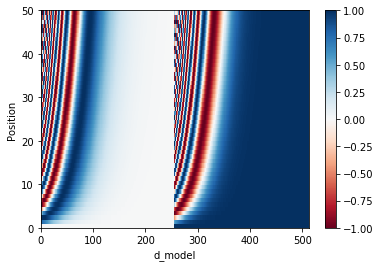

In [52]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d_model')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [53]:
class Encoder(tf.keras.layers.Layer):
    # Encoder 的初始參數除了本來就要給 EncoderLayer 的參數還多了：
    # - num_layers: 決定要有幾個 EncoderLayers, 前面影片中的 `N`
    # - input_vocab_size: 用來把索引轉成詞嵌入向量
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
    
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
        # 建立 `num_layers` 個 EncoderLayers
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        # 輸入的 x.shape == (batch_size, input_seq_len)
        # 以下各 layer 的輸出皆為 (batch_size, input_seq_len, d_model)
        input_seq_len = tf.shape(x)[1]
    
        # 將 2 維的索引序列轉成 3 維的詞嵌入張量，並依照論文乘上 sqrt(d_model)
        # 再加上對應長度的位置編碼
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :input_seq_len, :]

        # 對 embedding 跟位置編碼的總合做 regularization
        # 這在 Decoder 也會做
        x = self.dropout(x, training=training)
    
        # 通過 N 個 EncoderLayer 做編碼
        for i, enc_layer in enumerate(self.enc_layers):
            x = enc_layer(x, training, mask)
            # 以下只是用來 demo EncoderLayer outputs
            #print('-' * 20)
            #print(f"EncoderLayer {i + 1}'s output:", x)
      
    
        return x 

In [54]:
# 超參數
num_layers = 2 # 2 層的 Encoder
d_model = 4
num_heads = 2
dff = 8
input_vocab_size = subword_encoder_en.vocab_size + 2 # 記得加上 <start>, <end>

# 初始化一個 Encoder
encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size)

# 將 2 維的索引序列丟入 Encoder 做編碼
enc_out = encoder(inp, training=False, mask=None)
print("inp:", inp)
print("-" * 20)
print("enc_out:", enc_out)

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)
--------------------
enc_out: tf.Tensor(
[[[-0.80654085 -0.5846038  -0.31439856  1.7055433 ]
  [-0.46891177 -0.5740812  -0.6840382   1.7270311 ]
  [-0.31970912 -0.17782499 -1.119148    1.616682  ]
  [-0.49274144  0.2699072  -1.2412685   1.4641029 ]
  [-0.88477206  0.16279446 -0.8493917   1.5713693 ]
  [-0.96625346 -0.25279266 -0.45335197  1.6723981 ]
  [-0.84764326 -0.5615214  -0.2887244   1.6978891 ]
  [-0.61957765 -0.59192634 -0.51938546  1.7308896 ]]

 [[-0.80838823 -0.56457365 -0.33460814  1.7075701 ]
  [-0.50152004 -0.5214133  -0.7037289   1.7266624 ]
  [-0.34244883 -0.11313808 -1.1444561   1.600043  ]
  [-0.507244    0.21401623 -1.205033    1.4982607 ]
  [-0.8861126   0.26368496 -0.9036027   1.5260304 ]
  [-0.96629447 -0.21083693 -0.49055362  1.667685  ]
  [-0.868328   -0.5383214  -0.2883606   1.69501   ]
  [-0.6246327  -0.57586765 -0.530591    1.7310

In [55]:
class Decoder(tf.keras.layers.Layer):
    # 初始參數跟 Encoder 只差在用 `target_vocab_size` 而非 `inp_vocab_size`
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, 
               rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
    
        # 為中文（目標語言）建立詞嵌入層
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)
    
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
  
  # 呼叫時的參數跟 DecoderLayer 一模一樣
    def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    
        tar_seq_len = tf.shape(x)[1]
        attention_weights = {}  # 用來存放每個 Decoder layer 的注意權重
    
        # 這邊跟 Encoder 做的事情完全一樣
        x = self.embedding(x)  # (batch_size, tar_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :tar_seq_len, :]
        x = self.dropout(x, training=training)

        for i, dec_layer in enumerate(self.dec_layers):
              x, block1, block2 = dec_layer(x, enc_output, training,
                                    combined_mask, inp_padding_mask)
      
              # 將從每個 Decoder layer 取得的注意權重全部存下來回傳，方便我們觀察
              attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
              attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2
    
        # x.shape == (batch_size, tar_seq_len, d_model)
        return x, attention_weights

In [56]:
# 超參數
num_layers = 2 # 2 層的 Decoder
d_model = 4
num_heads = 2
dff = 8
target_vocab_size = subword_encoder_zh.vocab_size + 2 # 記得加上 <start>, <end>

# 遮罩
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化一個 Decoder
decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size)

# 將 2 維的索引序列以及遮罩丟入 Decoder
print("tar:", tar)
print("-" * 20)
print("combined_mask:", combined_mask)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("inp_padding_mask:", inp_padding_mask)
print("-" * 20)
dec_out, attn = decoder(tar, enc_out, training=False, 
                        combined_mask=combined_mask,
                        inp_padding_mask=inp_padding_mask)
print("dec_out:", dec_out)
print("-" * 20)
for block_name, attn_weights in attn.items():
    print(f"{block_name}.shape: {attn_weights.shape}")

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)
--------------------
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 10, 10), dtype=float32)
--------------------
enc_out: tf.Tensor(
[[[-0.80654085 

In [57]:
# Transformer 之上已經沒有其他 layers 了，我們使用 tf.keras.Model 建立一個模型
class Transformer(tf.keras.Model):
    # 初始參數包含 Encoder & Decoder 都需要超參數以及中英字典數目
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, rate)
        # 這個 FFN 輸出跟中文字典一樣大的 logits 數，等通過 softmax 就代表每個中文字的出現機率
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
    # enc_padding_mask 跟 dec_padding_mask 都是英文序列的 padding mask，
    # 只是一個給 Encoder layer 的 MHA 用，一個是給 Decoder layer 的 MHA 2 使用
    def call(self, inp, tar, training, enc_padding_mask, 
           combined_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
        tar, enc_output, training, combined_mask, dec_padding_mask)
    
        # 將 Decoder 輸出通過最後一個 linear layer
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
        return final_output, attention_weights

In [58]:
# 超參數
num_layers = 1
d_model = 4
num_heads = 2
dff = 8

# + 2 是為了 <start> & <end> token
input_vocab_size = subword_encoder_en.vocab_size + 2
output_vocab_size = subword_encoder_zh.vocab_size + 2

# 重點中的重點。訓練時用前一個字來預測下一個中文字
tar_inp = tar[:, :-1]
tar_real = tar[:, 1:]

# 來源 / 目標語言用的遮罩。注意 `comined_mask` 已經將目標語言的兩種遮罩合而為一
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar_inp)
look_ahead_mask = create_look_ahead_mask(tar_inp.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化我們的第一個 transformer
transformer = Transformer(num_layers, d_model, num_heads, dff, 
                          input_vocab_size, output_vocab_size)

# 將英文、中文序列丟入取得 Transformer 預測下個中文字的結果
predictions, attn_weights = transformer(inp, tar_inp, False, inp_padding_mask, 
                                        combined_mask, inp_padding_mask)

print("tar:", tar)
print("-" * 20)
print("tar_inp:", tar_inp)
print("-" * 20)
print("tar_real:", tar_real)
print("-" * 20)
print("predictions:", predictions)

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)
--------------------
tar_inp: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0]
 [4201  162  467  421  189   14    7  553    3]], shape=(2, 9), dtype=int64)
--------------------
tar_real: tf.Tensor(
[[  10  241   80   27    3 4202    0    0    0]
 [ 162  467  421  189   14    7  553    3 4202]], shape=(2, 9), dtype=int64)
--------------------
predictions: tf.Tensor(
[[[ 0.00929453 -0.01123782  0.05421777 ... -0.01170466  0.00628542
   -0.07576236]
  [ 0.03640016 -0.0188504   0.05113849 ... -0.02349907  0.01716621
   -0.06729947]
  [ 0.05617092 -0.02265773  0.04667147 ... -0.02913138  0.02415059
   -0.05331098]
  ...
  [ 0.00905134 -0.01058669  0.05486142 ... -0.01039154  0.0058039
   -0.07445519]
  [ 0.0221561  -0.01478041  0.0537539  ... -0.0170105   0.01135763
   -0.07241639]
  [ 0.0478656  -0.02148081  0.04837157 ... -0.0275

In [59]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# 假設我們要解的是一個 binary classifcation， 0 跟 1 個代表一個 label
real = tf.constant([1, 1, 0], shape=(1, 3), dtype=tf.float32)
pred = tf.constant([[0, 1], [0, 1], [0, 1]], dtype=tf.float32)
loss_object(real, pred)

<tf.Tensor: id=631047, shape=(3,), dtype=float32, numpy=array([0.31326166, 0.31326166, 1.3132616 ], dtype=float32)>

In [60]:
print("predictions:", predictions)
print("-" * 20)
print(tf.reduce_sum(predictions, axis=-1))

predictions: tf.Tensor(
[[[ 0.00929453 -0.01123782  0.05421777 ... -0.01170466  0.00628542
   -0.07576236]
  [ 0.03640016 -0.0188504   0.05113849 ... -0.02349907  0.01716621
   -0.06729947]
  [ 0.05617092 -0.02265773  0.04667147 ... -0.02913138  0.02415059
   -0.05331098]
  ...
  [ 0.00905134 -0.01058669  0.05486142 ... -0.01039154  0.0058039
   -0.07445519]
  [ 0.0221561  -0.01478041  0.0537539  ... -0.0170105   0.01135763
   -0.07241639]
  [ 0.0478656  -0.02148081  0.04837157 ... -0.02759764  0.02148173
   -0.06043392]]

 [[ 0.00996659 -0.01115558  0.05453674 ... -0.0114185   0.00637142
   -0.07500789]
  [ 0.03897631 -0.01930442  0.05089559 ... -0.02409907  0.01803425
   -0.06564319]
  [ 0.05387271 -0.02244362  0.04702405 ... -0.02893805  0.02348556
   -0.05554679]
  ...
  [ 0.01048943 -0.01085558  0.05502524 ... -0.01070841  0.0062833
   -0.0738526 ]
  [ 0.02370837 -0.01504853  0.05381611 ... -0.01732858  0.01186723
   -0.07158873]
  [ 0.04920106 -0.02166032  0.0481827  ... -0.02781

In [61]:
def loss_function(real, pred):
    # 這次的 mask 將序列中不等於 0 的位置視為 1，其餘為 0 
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # 照樣計算所有位置的 cross entropy 但不加總
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask  # 只計算非 <pad> 位置的損失 
  
    return tf.reduce_mean(loss_)

In [62]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [63]:
num_layers = 4 
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = subword_encoder_en.vocab_size + 2
target_vocab_size = subword_encoder_zh.vocab_size + 2
dropout_rate = 0.1  # 預設值

print("input_vocab_size:", input_vocab_size)
print("target_vocab_size:", target_vocab_size)

input_vocab_size: 8137
target_vocab_size: 4203


In [64]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    # 論文預設 `warmup_steps` = 4000
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5,0,'Train Step')

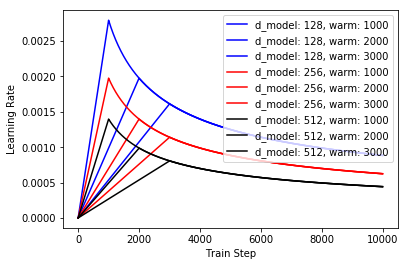

In [65]:
d_models = [128, 256, 512]
warmup_steps = [1000 * i for i in range(1, 4)]

schedules = []
labels = []
colors = ["blue", "red", "black"]
for d in d_models:
    schedules += [CustomSchedule(d, s) for s in warmup_steps]
    labels += [f"d_model: {d}, warm: {s}" for s in warmup_steps]

for i, (schedule, label) in enumerate(zip(schedules, labels)):
    plt.plot(schedule(tf.range(10000, dtype=tf.float32)), 
           label=label, color=colors[i // 3])

plt.legend()

plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [66]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, dropout_rate)

print(f"""這個 Transformer 有 {num_layers} 層 Encoder / Decoder layers
d_model: {d_model}
num_heads: {num_heads}
dff: {dff}
input_vocab_size: {input_vocab_size}
target_vocab_size: {target_vocab_size}
dropout_rate: {dropout_rate}

""")

這個 Transformer 有 4 層 Encoder / Decoder layers
d_model: 128
num_heads: 8
dff: 512
input_vocab_size: 8137
target_vocab_size: 4203
dropout_rate: 0.1




In [67]:
# 方便比較不同實驗/ 不同超參數設定的結果
run_id = f"{num_layers}layers_{d_model}d_{num_heads}heads_{dff}dff_{train_perc}train_perc"
checkpoint_path = os.path.join(checkpoint_path, run_id)
log_dir = os.path.join(log_dir, run_id)

# tf.train.Checkpoint 可以幫我們把想要存下來的東西整合起來，方便儲存與讀取
# 一般來說你會想存下模型以及 optimizer 的狀態
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

# ckpt_manager 會去 checkpoint_path 看有沒有符合 ckpt 裡頭定義的東西
# 存檔的時候只保留最近 5 次 checkpoints，其他自動刪除
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果在 checkpoint 路徑上有發現檔案就讀進來
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
  
    # 用來確認之前訓練多少 epochs 了
    last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    print(f'已讀取最新的 checkpoint，模型已訓練 {last_epoch} epochs。')
else:
    last_epoch = 0
    print("沒找到 checkpoint，從頭訓練。")

已讀取最新的 checkpoint，模型已訓練 3 epochs。


In [68]:
# 為 Transformer 的 Encoder / Decoder 準備遮罩
def create_masks(inp, tar):
    # 英文句子的 padding mask，要交給 Encoder layer 自注意力機制用的
    enc_padding_mask = create_padding_mask(inp)
  
    # 同樣也是英文句子的 padding mask，但是是要交給 Decoder layer 的 MHA 2 
    # 關注 Encoder 輸出序列用的
    dec_padding_mask = create_padding_mask(inp)
  
    # Decoder layer 的 MHA1 在做自注意力機制用的
    # `combined_mask` 是中文句子的 padding mask 跟 look ahead mask 的疊加
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [69]:
@tf.function  # 讓 TensorFlow 幫我們將 eager code 優化並加快運算
def train_step(inp, tar):
  # 前面說過的，用去尾的原始序列去預測下一個字的序列
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    # 建立 3 個遮罩
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    # 紀錄 Transformer 的所有運算過程以方便之後做梯度下降
    with tf.GradientTape() as tape:
        # 注意是丟入 `tar_inp` 而非 `tar`。記得將 `training` 參數設定為 True
        predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
        # 跟影片中顯示的相同，計算左移一個字的序列跟模型預測分佈之間的差異，當作 loss
        loss = loss_function(tar_real, predictions)

    # 取出梯度並呼叫前面定義的 Adam optimizer 幫我們更新 Transformer 裡頭可訓練的參數
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    # 將 loss 以及訓練 acc 記錄到 TensorBoard 上，非必要
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [70]:
# 定義我們要看幾遍數據集
EPOCHS = 5
print(f"此超參數組合的 Transformer 已經訓練 {last_epoch} epochs。")
print(f"剩餘 epochs：{min(0, last_epoch - EPOCHS)}")


# 用來寫資訊到 TensorBoard，非必要但十分推薦
summary_writer = tf.summary.create_file_writer(log_dir)

# 比對設定的 `EPOCHS` 以及已訓練的 `last_epoch` 來決定還要訓練多少 epochs
for epoch in range(last_epoch, EPOCHS):
    start = time.time()
  
    # 重置紀錄 TensorBoard 的 metrics
    train_loss.reset_states()
    train_accuracy.reset_states()
  
    # 一個 epoch 就是把我們定義的訓練資料集一個一個 batch 拿出來處理，直到看完整個數據集 
    for (step_idx, (inp, tar)) in enumerate(train_dataset):
        # 每次 step 就是將數據丟入 Transformer，讓它生預測結果並計算梯度最小化 loss
        train_step(inp, tar)
        print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                  epoch + 1, step_idx, train_loss.result(), train_accuracy.result()))

    # 每個 epoch 完成就存一次檔    
    if (epoch + 1) % 1 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
    # 將 loss 以及 accuracy 寫到 TensorBoard 上
    with summary_writer.as_default():
        tf.summary.scalar("train_loss", train_loss.result(), step=epoch + 1)
        tf.summary.scalar("train_acc", train_accuracy.result(), step=epoch + 1)
  
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))
    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

此超參數組合的 Transformer 已經訓練 3 epochs。
剩餘 epochs：-2
Epoch 4 Batch 0 Loss 3.3631 Accuracy 0.1767
Epoch 4 Batch 1 Loss 3.1663 Accuracy 0.1716
Epoch 4 Batch 2 Loss 3.1788 Accuracy 0.1701
Epoch 4 Batch 3 Loss 3.1697 Accuracy 0.1676
Epoch 4 Batch 4 Loss 3.1940 Accuracy 0.1667
Epoch 4 Batch 5 Loss 3.1872 Accuracy 0.1665
Epoch 4 Batch 6 Loss 3.1485 Accuracy 0.1658
Epoch 4 Batch 7 Loss 3.1415 Accuracy 0.1643
Epoch 4 Batch 8 Loss 3.1332 Accuracy 0.1638
Epoch 4 Batch 9 Loss 3.1274 Accuracy 0.1637
Epoch 4 Batch 10 Loss 3.1240 Accuracy 0.1631
Epoch 4 Batch 11 Loss 3.1222 Accuracy 0.1638
Epoch 4 Batch 12 Loss 3.1221 Accuracy 0.1648
Epoch 4 Batch 13 Loss 3.1097 Accuracy 0.1647
Epoch 4 Batch 14 Loss 3.1201 Accuracy 0.1651
Epoch 4 Batch 15 Loss 3.1291 Accuracy 0.1653
Epoch 4 Batch 16 Loss 3.1376 Accuracy 0.1655
Epoch 4 Batch 17 Loss 3.1426 Accuracy 0.1662
Epoch 4 Batch 18 Loss 3.1334 Accuracy 0.1661
Epoch 4 Batch 19 Loss 3.1290 Accuracy 0.1663
Epoch 4 Batch 20 Loss 3.1311 Accuracy 0.1662
Epoch 4 Batch 21 

Epoch 4 Batch 180 Loss 3.0528 Accuracy 0.1736
Epoch 4 Batch 181 Loss 3.0528 Accuracy 0.1737
Epoch 4 Batch 182 Loss 3.0523 Accuracy 0.1738
Epoch 4 Batch 183 Loss 3.0525 Accuracy 0.1739
Epoch 4 Batch 184 Loss 3.0523 Accuracy 0.1740
Epoch 4 Batch 185 Loss 3.0521 Accuracy 0.1741
Epoch 4 Batch 186 Loss 3.0513 Accuracy 0.1741
Epoch 4 Batch 187 Loss 3.0501 Accuracy 0.1742
Epoch 4 Batch 188 Loss 3.0490 Accuracy 0.1742
Epoch 4 Batch 189 Loss 3.0490 Accuracy 0.1743
Epoch 4 Batch 190 Loss 3.0486 Accuracy 0.1743
Epoch 4 Batch 191 Loss 3.0486 Accuracy 0.1744
Epoch 4 Batch 192 Loss 3.0479 Accuracy 0.1744
Epoch 4 Batch 193 Loss 3.0475 Accuracy 0.1745
Epoch 4 Batch 194 Loss 3.0470 Accuracy 0.1746
Epoch 4 Batch 195 Loss 3.0473 Accuracy 0.1746
Epoch 4 Batch 196 Loss 3.0466 Accuracy 0.1747
Epoch 4 Batch 197 Loss 3.0453 Accuracy 0.1748
Epoch 4 Batch 198 Loss 3.0448 Accuracy 0.1748
Epoch 4 Batch 199 Loss 3.0437 Accuracy 0.1749
Epoch 4 Batch 200 Loss 3.0422 Accuracy 0.1749
Epoch 4 Batch 201 Loss 3.0419 Accu

Epoch 5 Batch 123 Loss 2.8442 Accuracy 0.1909
Epoch 5 Batch 124 Loss 2.8432 Accuracy 0.1909
Epoch 5 Batch 125 Loss 2.8425 Accuracy 0.1910
Epoch 5 Batch 126 Loss 2.8412 Accuracy 0.1908
Epoch 5 Batch 127 Loss 2.8410 Accuracy 0.1908
Epoch 5 Batch 128 Loss 2.8407 Accuracy 0.1908
Epoch 5 Batch 129 Loss 2.8394 Accuracy 0.1908
Epoch 5 Batch 130 Loss 2.8395 Accuracy 0.1908
Epoch 5 Batch 131 Loss 2.8410 Accuracy 0.1909
Epoch 5 Batch 132 Loss 2.8400 Accuracy 0.1909
Epoch 5 Batch 133 Loss 2.8404 Accuracy 0.1910
Epoch 5 Batch 134 Loss 2.8404 Accuracy 0.1911
Epoch 5 Batch 135 Loss 2.8407 Accuracy 0.1912
Epoch 5 Batch 136 Loss 2.8413 Accuracy 0.1913
Epoch 5 Batch 137 Loss 2.8412 Accuracy 0.1913
Epoch 5 Batch 138 Loss 2.8405 Accuracy 0.1913
Epoch 5 Batch 139 Loss 2.8407 Accuracy 0.1913
Epoch 5 Batch 140 Loss 2.8395 Accuracy 0.1913
Epoch 5 Batch 141 Loss 2.8394 Accuracy 0.1914
Epoch 5 Batch 142 Loss 2.8395 Accuracy 0.1915
Epoch 5 Batch 143 Loss 2.8393 Accuracy 0.1914
Epoch 5 Batch 144 Loss 2.8400 Accu

In [71]:
# 給定一個英文句子，輸出預測的中文索引數字序列以及注意權重 dict
def evaluate(inp_sentence):
  
    # 準備英文句子前後會加上的 <start>, <end>
    start_token = [subword_encoder_en.vocab_size]
    end_token = [subword_encoder_en.vocab_size + 1]
  
    # inp_sentence 是字串，我們用 Subword Tokenizer 將其變成子詞的索引序列並在前後加上 BOS / EOS
    inp_sentence = start_token + subword_encoder_en.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)
  
    # 第一個時間點吃進去的輸入是一個只包含一個中文 <start> token 的序列
    decoder_input = [subword_encoder_zh.vocab_size]
    output = tf.expand_dims(decoder_input, 0)  # 增加 batch 維度
  
    # auto-regressive，一次生成一個中文字並將預測加到輸入再度餵進 Transformer
    for i in range(MAX_LENGTH):
        # 每多一個生成的字就得產生新的遮罩
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
  
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    

        # 將序列中最後一個 distribution 取出，並將裡頭值最大的當作模型最新的預測字
        predictions = predictions[: , -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
        # 遇到 <end> token 就停止回傳，代表模型已經產生完結果
        if tf.equal(predicted_id, subword_encoder_zh.vocab_size + 1):
            return tf.squeeze(output, axis=0), attention_weights
    
        #將 Transformer 新預測的中文索引加到輸出序列中，讓 Decoder 可以在產生
        # 下個中文字的時候關注到最新的 `predicted_id`
        output = tf.concat([output, predicted_id], axis=-1)

    # 將 batch 的維度去掉後回傳預測的中文索引序列
    return tf.squeeze(output, axis=0), attention_weights

In [72]:
# 要被翻譯的英文句子
sentence = "China, India, and others have enjoyed continuing economic growth."

# 取得預測的中文索引序列
predicted_seq, _ = evaluate(sentence)

# 過濾掉 <start> & <end> tokens 並用中文的 subword tokenizer 幫我們將索引序列還原回中文句子
target_vocab_size = subword_encoder_zh.vocab_size
predicted_seq_without_bos_eos = [idx for idx in predicted_seq if idx < target_vocab_size]
predicted_sentence = subword_encoder_zh.decode(predicted_seq_without_bos_eos)

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("predicted_sentence:", predicted_sentence)

sentence: China, India, and others have enjoyed continuing economic growth.
--------------------
predicted_seq: tf.Tensor(
[4201   29    5   10   64    4   33    2   16    4    1   22   52  119
  200  153   43    6    7   31    4   33    3], shape=(23,), dtype=int32)
--------------------
predicted_sentence: 而在这些国家，中国的经济体系统也是一个国家。


In [73]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  1834624   
_________________________________________________________________
decoder_2 (Decoder)          multiple                  1596288   
_________________________________________________________________
dense_137 (Dense)            multiple                  542187    
Total params: 3,973,099
Trainable params: 3,973,099
Non-trainable params: 0
_________________________________________________________________


In [74]:
predicted_seq, attention_weights = evaluate(sentence)

# 在這邊我們自動選擇最後一個 Decoder layer 的 MHA 2，也就是 Decoder 關注 Encoder 的 MHA
layer_name = f"decoder_layer{num_layers}_block2"

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("attention_weights.keys():")
for layer_name, attn in attention_weights.items():
    print(f"{layer_name}.shape: {attn.shape}")
print("-" * 20)
print("layer_name:", layer_name)

sentence: China, India, and others have enjoyed continuing economic growth.
--------------------
predicted_seq: tf.Tensor(
[4201   29    5   10   64    4   33    2   16    4    1   22   52  119
  200  153   43    6    7   31    4   33    3], shape=(23,), dtype=int32)
--------------------
attention_weights.keys():
decoder_layer1_block1.shape: (1, 8, 23, 23)
decoder_layer1_block2.shape: (1, 8, 23, 15)
decoder_layer2_block1.shape: (1, 8, 23, 23)
decoder_layer2_block2.shape: (1, 8, 23, 15)
decoder_layer3_block1.shape: (1, 8, 23, 23)
decoder_layer3_block2.shape: (1, 8, 23, 15)
decoder_layer4_block1.shape: (1, 8, 23, 23)
decoder_layer4_block2.shape: (1, 8, 23, 15)
--------------------
layer_name: decoder_layer4_block2


In [77]:
import matplotlib as mpl
# 你可能會需要自行下載一個中文字體檔案以讓 matplotlib 正確顯示中文
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/SimHei/simhei.ttf')
plt.style.use("seaborn-whitegrid")

# 這個函式將英 -> 中翻譯的注意權重視覺化（注意：我們將注意權重 transpose 以最佳化渲染結果
def plot_attention_weights(attention_weights, sentence, predicted_seq, layer_name, max_len_tar=None):
    
    fig = plt.figure(figsize=(17, 7))
  
    sentence = subword_encoder_en.encode(sentence)
  
    # 只顯示中文序列前 `max_len_tar` 個字以避免畫面太過壅擠
    if max_len_tar:
        predicted_seq = predicted_seq[:max_len_tar]
    else:
        max_len_tar = len(predicted_seq)
  
    # 將某一個特定 Decoder layer 裡頭的 MHA 1 或 MHA2 的注意權重拿出來並去掉 batch 維度
    attention_weights = tf.squeeze(attention_weights[layer_name], axis=0)  
    # (num_heads, tar_seq_len, inp_seq_len)
  
    # 將每個 head 的注意權重畫出
    for head in range(attention_weights.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)

        # [注意]我為了將長度不短的英文子詞顯示在 y 軸，將注意權重做了 transpose
        attn_map = np.transpose(attention_weights[head][:max_len_tar, :])
        ax.matshow(attn_map, cmap='viridis')  # (inp_seq_len, tar_seq_len)
    
        #fontdict = {"fontproperties": zhfont}
    
        ax.set_xticks(range(max(max_len_tar, len(predicted_seq))))
        ax.set_xlim(-0.5, max_len_tar -1.5)
    
        ax.set_yticks(range(len(sentence) + 2))
        ax.set_xticklabels([subword_encoder_zh.decode([i]) for i in predicted_seq 
                        if i < subword_encoder_zh.vocab_size], fontsize=18)    
    
        ax.set_yticklabels(
            ['<start>'] + [subword_encoder_en.decode([i]) for i in sentence] + ['<end>'])
    
        ax.set_xlabel('Head {}'.format(head + 1))
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)
  
    plt.tight_layout()
    plt.show()
    plt.close(fig)

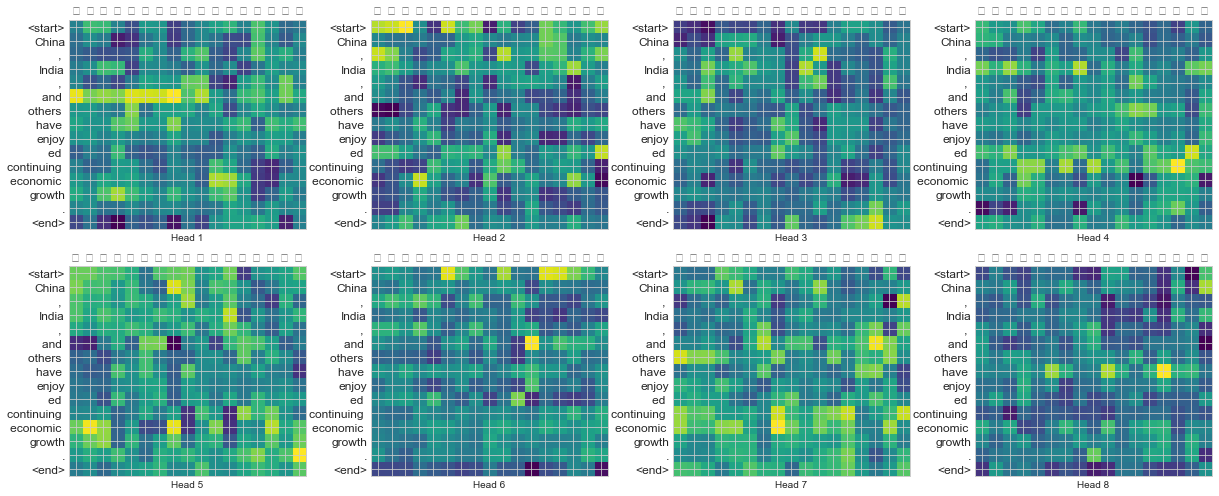

In [78]:
plot_attention_weights(attention_weights, sentence, 
                       predicted_seq, layer_name, max_len_tar=18)